In [1]:
import torch

# CONTENT_FILES = './input/cpl'
# STYLE_FILES = './input/clb'
CONTENT_FILES = './input/clp/long'
STYLE_FILES = './input/laplus/long'

windowSize = 48         # the input width of the model
vecLen = 128            # length of vector generated by siamese vector
shape = 24              # length of time axis of split specrograms to feed to generator            

batch_size = 32         #batch size



# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

In [2]:


from TraVeLGAN.processing import wav2spectrum, sampleRate
from utils import loadFile
from glob import glob
import torch

def loadData(path):
    files = glob(f'{path}/*.wav')
    data = []
    for file in files:
        x = loadFile(file, sampleRate)
        data.append(x)
    print(f'loaded {len(files)} files from {path}')
    return data


def transformData(Xs):
    ret = []
    for x in Xs:
        ret.append(wav2spectrum(x))
    return ret
    

x_content = loadData(CONTENT_FILES)
x_style = loadData(STYLE_FILES)


a_content = transformData(x_content)
a_style = transformData(x_style)


print(f'sampleRate: {sampleRate}')



# Making Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class myDataset(Dataset):
    def __init__(self, content, style, sampleNumber = 60):
        self.style = []
        self.content = []
        for c, s in zip(content, style):
            H_S, W_S = s.shape
            H_C, W_C = c.shape 
            indices_C = np.random.randint(W_C - windowSize, size = sampleNumber)
            indices_S = np.random.randint(W_S - windowSize, size = sampleNumber)
        
            for i in indices_C:
                tensor = torch.tensor(c[None, :, i: i + windowSize])
                self.content.append(tensor)

            for i in indices_S:
                tensor = torch.tensor(s[None, :, i: i + windowSize])
                self.style.append(tensor)

    def __getitem__(self, index):
        return self.content[index], self.style[index]

    def __len__(self):
        return len(self.content)

dataset = myDataset(a_content, a_style)

train_loader = DataLoader(
    dataset, batch_size = batch_size
)

print(f'Load {len(dataset)} samples')


Load 60 samples


# Settings

In [ ]:

learning_rate = 0.00001
# learning_rate_G = 0.00001
# learning_rate_D = 0.000005

"""
L_S = beta L_{(G, S), TraVeL} + gamma L_{S, margin}
L_G = L_{G, adv} + alpha L_{G, id} + beta L_{(G, S), TraVeL}
L_D = L_{D, adv}
"""

alpha = 1.0
delta = 2.0
beta = 10.0
gamma = 10.0

S_weight = 1.0
G_weight = 1.0
D_weight = 10.0


max_epochs = 30      # maximum epochs

load_model_path = './saved_model/test4'  # path of the pretrained model
saved_experiment_path = './saved_model/clptolapus_2'   # path of the saved model
test_waveform_file = './input/clp/short/clp_test.wav'

if not os.path.exists(saved_experiment_path):
    os.mkdir(saved_experiment_path)

    
plot_spec = True    # plot spectrum when training 
saved_epoch = 3      # save model period

pretrained = False   # If loading the pretrained model 




# Training

Training Epoch 003/030: 100%|██████████| 2/2 [00:00<00:00, 14.82batch/s, S=66.2, G=66.1, D=3.61]
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


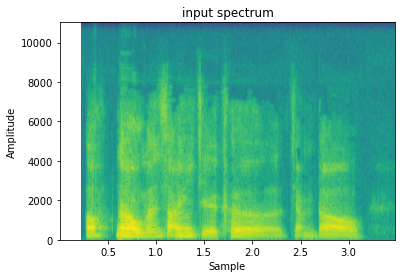

100%|██████████| 2000/2000 [00:46<00:00, 43.06it/s, loss=0.00104, spectral_convergence=-11]  


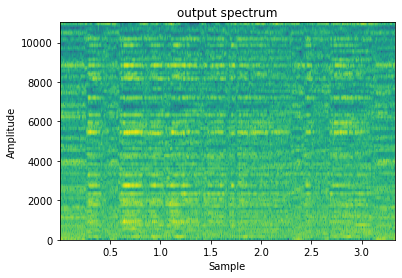

Save model and generate waveform at epoch 3, total loss: 134.07963943481445


Training Epoch 006/030: 100%|██████████| 2/2 [00:00<00:00, 17.38batch/s, S=53.9, G=53.8, D=3.03]


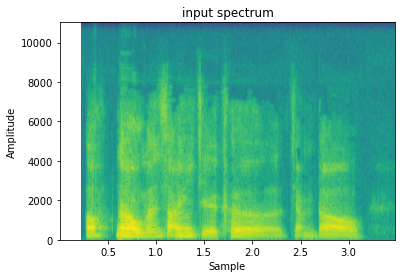

100%|██████████| 2000/2000 [00:48<00:00, 41.60it/s, loss=0.0134, spectral_convergence=-11.4]


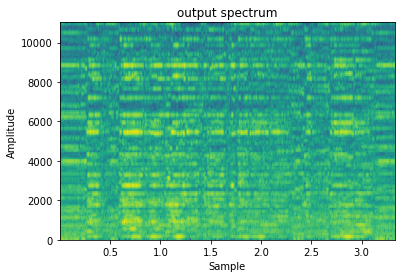

Save model and generate waveform at epoch 6, total loss: 109.26234340667725


Training Epoch 009/030: 100%|██████████| 2/2 [00:00<00:00, 16.95batch/s, S=44.3, G=44.3, D=2.47]


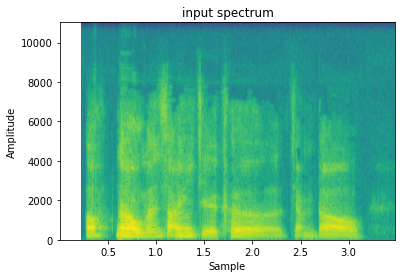

100%|██████████| 2000/2000 [00:47<00:00, 41.78it/s, loss=0.0651, spectral_convergence=-9.86]


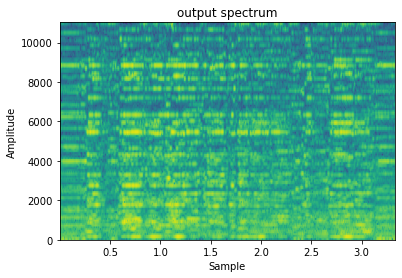

Save model and generate waveform at epoch 9, total loss: 89.87419605255127


Training Epoch 012/030: 100%|██████████| 2/2 [00:00<00:00, 15.88batch/s, S=36.2, G=36.2, D=2.13]


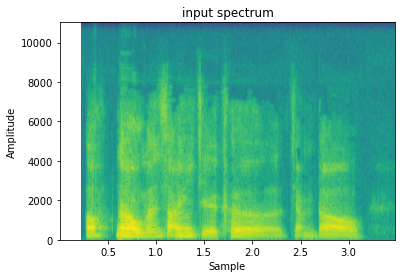

100%|██████████| 2000/2000 [00:47<00:00, 41.78it/s, loss=0.0983, spectral_convergence=-9.58]


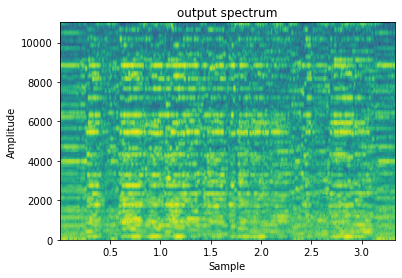

Save model and generate waveform at epoch 12, total loss: 73.55409836769104


Training Epoch 015/030: 100%|██████████| 2/2 [00:00<00:00, 17.69batch/s, S=29.1, G=29.2, D=1.79]


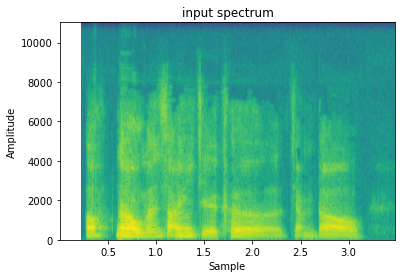

100%|██████████| 2000/2000 [00:47<00:00, 42.12it/s, loss=0.106, spectral_convergence=-9.69]


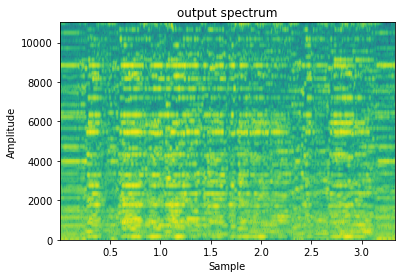

Save model and generate waveform at epoch 15, total loss: 59.29030096530914


Training Epoch 018/030: 100%|██████████| 2/2 [00:00<00:00, 15.04batch/s, S=22.8, G=23, D=1.44]


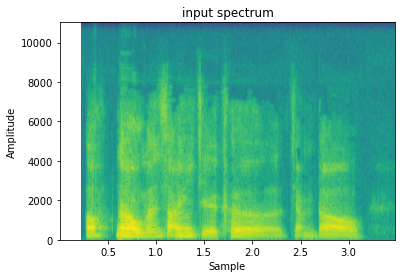

100%|██████████| 2000/2000 [00:48<00:00, 40.83it/s, loss=0.106, spectral_convergence=-9.73]


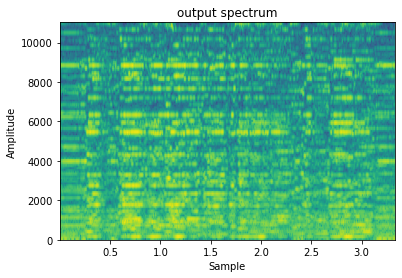

Save model and generate waveform at epoch 18, total loss: 46.58470195531845


Training Epoch 021/030: 100%|██████████| 2/2 [00:00<00:00, 16.66batch/s, S=17.5, G=18, D=1]


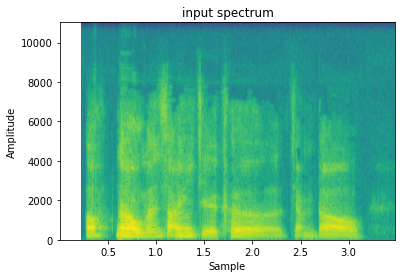

100%|██████████| 2000/2000 [00:48<00:00, 41.14it/s, loss=0.106, spectral_convergence=-9.77]


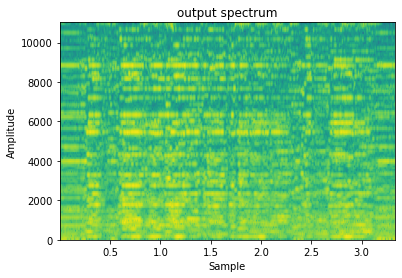

Save model and generate waveform at epoch 21, total loss: 36.078046441078186


Training Epoch 024/030: 100%|██████████| 2/2 [00:00<00:00, 16.71batch/s, S=15.5, G=16.2, D=0.588]


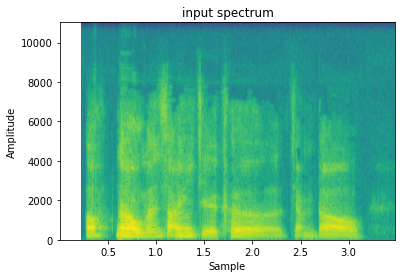

100%|██████████| 2000/2000 [00:47<00:00, 41.75it/s, loss=0.105, spectral_convergence=-9.84]


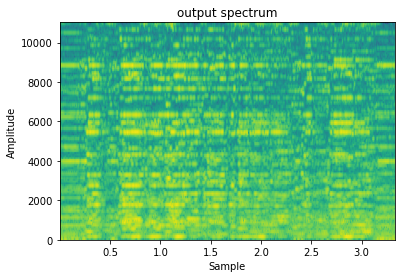

Save model and generate waveform at epoch 24, total loss: 31.984552085399628


Training Epoch 027/030: 100%|██████████| 2/2 [00:00<00:00, 17.22batch/s, S=14.7, G=15.6, D=0.327]


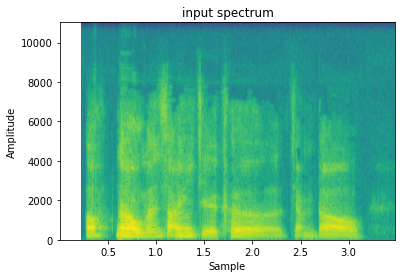

100%|██████████| 2000/2000 [00:48<00:00, 40.83it/s, loss=0.105, spectral_convergence=-9.89]


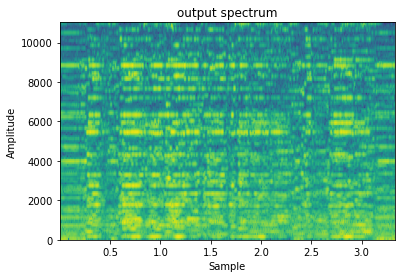

Save model and generate waveform at epoch 27, total loss: 30.379502028226852


Training Epoch 030/030: 100%|██████████| 2/2 [00:00<00:00, 17.06batch/s, S=13.5, G=14.4, D=0.222]


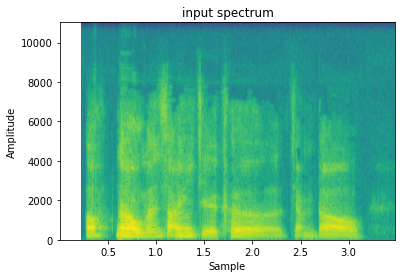

100%|██████████| 2000/2000 [00:45<00:00, 43.51it/s, loss=0.105, spectral_convergence=-9.87]


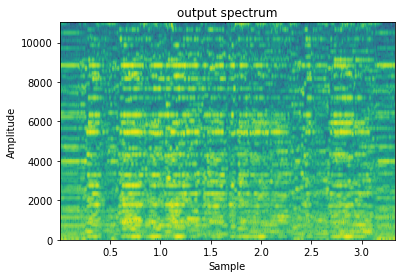

Save model and generate waveform at epoch 30, total loss: 27.9705298691988


In [ ]:

from TraVeLGAN.processing import spectrum2wav, hop, sampleRate
from TraVeLGAN.models import Siamese, Generater, Discriminator
from utils import plot_spectrogram_with_raw_signal
from TraVeLGAN.loss import *
from utils import writeFile
import torch.optim as optim
from tqdm import tqdm
import pickle as pkl
import torch 
import os

# Crop function for training
def crop(x):
    return x[:, :, :, :shape], x[:, :, :, shape:]


model_S = Siamese(input_size = (1, hop, shape), output_size = vecLen)
model_G = Generater(input_size = (1, hop, shape))
model_D = Discriminator(input_size = (1, hop, windowSize))


# load pretrained model
if pretrained :
    model_S.load_state_dict(torch.load(os.path.join(load_model_path, 'model_S.pt')))
    model_G.load_state_dict(torch.load(os.path.join(load_model_path, 'model_G.pt')))
    model_D.load_state_dict(torch.load(os.path.join(load_model_path, 'model_D.pt')))


# optimizer_S = optim.Adam(
#     model_S.parameters(),
#     lr = learning_rate_S
# )

# optimizer_G = optim.Adam(
#     model_G.parameters(),
#     lr = learning_rate_G
# )

# optimizer_D = optim.Adam(
#     model_D.parameters(),
#     lr = learning_rate_D
# )


optimizer = optim.Adam(
    list(model_S.parameters()) + list(model_G.parameters()) + list(model_D.parameters()),
    lr = learning_rate
)

model_S.to(device)
model_G.to(device)
model_D.to(device)


model_S.train()
model_G.train()
model_D.train()

gupt = 3

losses = {
    'loss_id': [],
    'loss_m': [],
    'loss_dr': [],
    'loss_df': [],
    'loss_g': [],
    'loss_S': [],
    'loss_G': [],
    'loss_D': []
}

for epoch in range(1, max_epochs + 1):
    
    
    loss_g_epoch = 0.0
    loss_m_epoch = 0.0
    loss_id_epoch = 0.0
    loss_dr_epoch = 0.0
    loss_df_epoch = 0.0

    loss_S_epoch = 0.0
    loss_G_epoch = 0.0
    loss_D_epoch = 0.0
    


    with tqdm(train_loader, unit = 'batch') as tepoch:
        for i, (x, y) in enumerate(tepoch):
            
            tepoch.set_description(f'Training Epoch {epoch:03d}/{max_epochs:03d}')

            x = x.to(device)
            y = y.to(device)

            x1, x2 = crop(x)
            y1, y2 = crop(y)

            if i % gupt == 0: # Train all

                # optimizer_S.zero_grad()
                # optimizer_G.zero_grad()
                # optimizer_D.zero_grad()
                optimizer.zero_grad()

                gen_x_1 = model_G(x1)
                gen_x_2 = model_G(x2)
                
                gen_y_1 = model_G(y1)
                gen_y_2 = model_G(y2)

                gen = torch.cat([gen_x_1, gen_x_2], dim = -1)

                iden_gen = model_D(gen)
                iden_ori = model_D(y)

                siam_x_1_gen = model_S(gen_x_1)
                siam_x_2_gen = model_S(gen_x_2)

                siam_x_1 = model_S(x1)
                siam_x_2 = model_S(x2)


                # identity mapping loss
                loss_id = (mse(y1, gen_y_1) + mse(y2, gen_y_2)) / 2.0

                
                # margin loss
                loss_m = loss_margin(siam_x_1, siam_x_2, delta)


                # travel loss
                loss_t = loss_travel(siam_x_1, siam_x_1_gen, siam_x_2, siam_x_2_gen)


                # generator and critic losses
                loss_g = g_loss_f(iden_gen)
                loss_dr = d_loss_r(iden_ori)
                loss_df = d_loss_f(iden_gen)
                

                loss_D = loss_dr + loss_df

                loss_G = loss_g + alpha * loss_id + beta * loss_t

                loss_S = beta * loss_t + gamma * loss_m


                loss_g_epoch += loss_g.item()
                loss_m_epoch += loss_m.item()
                loss_id_epoch += loss_id.item()
                loss_dr_epoch += loss_dr.item()
                loss_df_epoch += loss_df.item()
                
                loss_S_epoch += loss_S.item()
                loss_G_epoch += loss_G.item()
                loss_D_epoch += loss_D.item()
                
                loss = S_weight * loss_S + G_weight  * loss_G + G_weight * loss_D

                loss.backward()

                optimizer.step()

                # loss_S.backward(retain_graph = True)
                # loss_G.backward(retain_graph = True)
                # loss_D.backward()       
                
                # optimizer_S.step()
                # optimizer_G.step()
                # optimizer_D.step()


            else: # Train Critic only
                
                # optimizer_D.zero_grad()
                optimizer.zero_grad()

                gen_x_1 = model_G(x1)
                gen_x_2 = model_G(x2)

                gen = torch.cat([gen_x_1, gen_x_2], dim = -1)

                iden_gen = model_D(gen)
                iden_ori = model_D(y)

                # zero tensor
                zero = torch.zeros(vecLen, device = device)

                loss_dr = d_loss_r(iden_ori)
                loss_df = d_loss_f(iden_gen)

                loss = loss_dr + loss_df

                loss_dr_epoch += loss_dr.item()
                loss_df_epoch += loss_df.item()

                loss_D += loss.item()

                loss.backward()
                optimizer.step()
                # optimizer_D.step()

            tepoch.set_postfix({'S': loss_S.item(), 'G': loss_G.item(), 'D': loss_D.item()})
            
    if epoch % saved_epoch == 0:

        epoch_path = os.path.join(saved_experiment_path, f'epoch_{epoch}')

        if not os.path.exists(epoch_path):
            os.mkdir(epoch_path)
 
        if os.path.exists(test_waveform_file):
        
            x_input = loadFile(test_waveform_file, sampleRate)

            if plot_spec:
                plot_spectrogram_with_raw_signal(x_input, sampleRate, 'input spectrum')

            a_input = wav2spectrum(x_input)
            H, W = a_input.shape

            W_output = W - (W % shape) 
            a_output = np.zeros((H, W_output))

            tensor_input = torch.tensor(a_input[:, :W_output])
            tensor_input = tensor_input.to(device)

            model_G.eval()

            for i in range(0, W_output, shape):
                a_output[:, i: i + shape] = model_G(tensor_input[:, i:i + shape].view(1, 1, H, shape)).detach().cpu().numpy()

            x_output = spectrum2wav(a_output)
        
            if plot_spec:
                plot_spectrogram_with_raw_signal(x_output, sampleRate, 'output spectrum')


            # save generated waveform
            writeFile(os.path.join(epoch_path, 'ori.wav'), x_input, sampleRate)
            writeFile(os.path.join(epoch_path, 'gen.wav'), x_output, sampleRate)

        # save models
        torch.save(model_S.state_dict(), os.path.join(epoch_path, 'model_S.pt'))
        torch.save(model_G.state_dict(), os.path.join(epoch_path, 'model_G.pt'))
        torch.save(model_D.state_dict(), os.path.join(epoch_path, 'model_D.pt'))

        print(f'Save model and generate waveform at epoch {epoch}, total loss: {loss_S_epoch + loss_G_epoch + loss_D_epoch}')
        
        model_G.train()



    losses['loss_g'].append(loss_g_epoch)
    losses['loss_m'].append(loss_m_epoch)
    losses['loss_id'].append(loss_id_epoch)
    losses['loss_dr'].append(loss_dr_epoch)
    losses['loss_df'].append(loss_df_epoch)

    
    losses['loss_S'].append(loss_S_epoch)
    losses['loss_G'].append(loss_G_epoch)
    losses['loss_D'].append(loss_D_epoch)
    
    

info = {
    'alpha': alpha,
    'beta': beta,
    'delta': delta,
    'gamma': gamma,
    'loss': losses,
    'epochs': max_epochs,
    'learning_rate': learning_rate,
    # 'learning_rate_S': learning_rate_S,
    # 'learning_rate_G': learning_rate_G,
    # 'learning_rate_D': learning_rate_D,
    'input_shape': (1, hop, windowSize),
    'vecLen': vecLen,
    'batch_size': batch_size,
    'saved_model_path': saved_experiment_path,
    'load_model_path': load_model_path,
    'pretrained': pretrained
}

with open(os.path.join(saved_experiment_path, 'train_info.pkl'), 'wb') as f:
    pkl.dump(info, f)

torch.save(model_S.state_dict(), os.path.join(saved_experiment_path, 'model_S.pt'))
torch.save(model_G.state_dict(), os.path.join(saved_experiment_path, 'model_G.pt'))
torch.save(model_D.state_dict(), os.path.join(saved_experiment_path, 'model_D.pt'))

 

# Show training process

[105.50422694161534, 19.20519182085991, 21.159911297261715, 19.390939002856612, 19.466139264404774, 24.828388027846813, 34.79913891106844, 20.356440879404545, 16.25841443799436, 17.89497384801507, 13.566138576716185, 16.31398143991828, 12.943990664556623, 9.698776695877314, 7.97136720456183, 7.8938080705702305, 10.210750427097082, 62.1912080924958, 53.98757398314774, 62.14545965194702, 45.250754261389375, 45.661184003576636, 75.03327439911664, 104.44106730818748, 93.65811454690993, 68.90185823664069, 112.68372393772006, 151.5366080570966, 186.34999975562096, 233.99514760635793, 378.708706818521, 236.51960573159158, 237.26142090559006, 262.9967615734786, 287.15403017774224, 403.626465909183, 399.1353140696883, 322.3310286067426, 427.66164772957563, 382.6422096975148, 468.1118274256587, 285.80066626518965, 1102.9849324040115, 648.1645883843303, 686.6320758834481, 686.2927728891373, 683.7996087819338, 679.8336772173643, 649.8737797737122, 1038.2541715055704, 455.1316281184554, 1481.334078

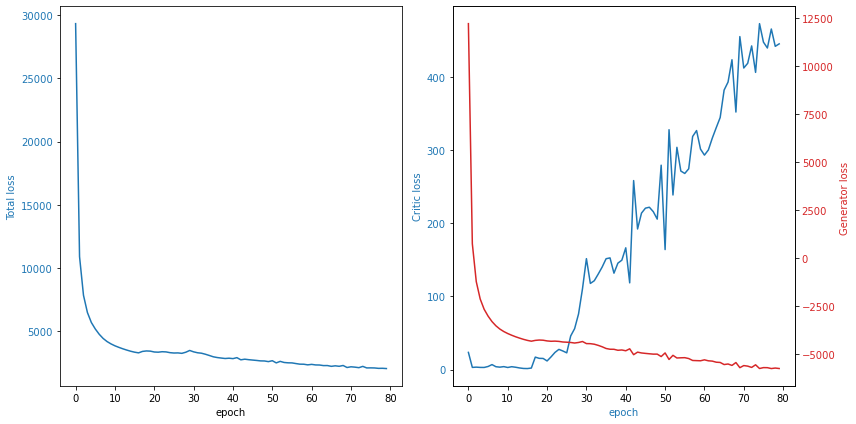

In [ ]:

# print(losses['loss_g'])

print(losses['loss_df'])

total_loss = np.array(losses['loss_S']) + np.array(losses['loss_G']) + np.array(losses['loss_D'])

plot_curve(losses['loss_D'], losses['loss_G'], total_loss, 'Critic loss', 'Generator loss ', 'Total loss', False)
# plot_curve(losses['loss_g'])
# print(losses['loss_m'])
# print(losses['loss_g'])
# print(losses['loss_GS'])




# Load Model

In [ ]:

from TraVeLGAN.models import Siamese, Generater, Discriminator
from TraVeLGAN.processing import hop


model_S = Siamese(input_size = (1, hop, windowSize // 3), output_size = vecLen)
model_G = Generater(input_size = (1, hop, windowSize // 3))
model_D = Discriminator(input_size = (1, hop, windowSize))


model_S.load_state_dict(torch.load(os.path.join(load_model_path, 'model_S.pt')))
model_G.load_state_dict(torch.load(os.path.join(load_model_path, 'model_G.pt')))
model_D.load_state_dict(torch.load(os.path.join(load_model_path, 'model_D.pt')))


<All keys matched successfully>

# Generate output



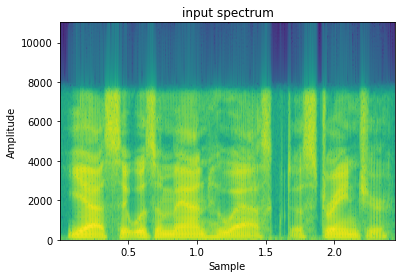

192 281


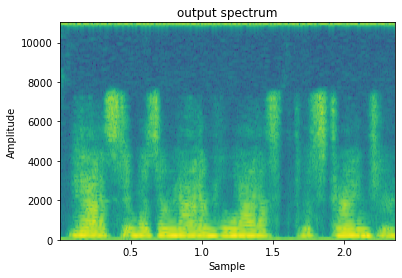

In [ ]:

# from preprocess import *
from utils import *

INPUT_FILE = './input/bdl/arctic_a0063.wav'

N_FFT = 512


x_input = loadFile(INPUT_FILE)
a_input = wav2spectrum(x_input)

plot_spectrogram_with_raw_signal(x_input, sampleRate, 'input spectrum')


H, W = a_input.shape
print(H, W)

w = windowSize // 3

W_output = W - (W % w) 
a_output = np.zeros((H, W_output))


# tensor_input = torch.transpose(torch.transpose(torch.tensor(a_input[:, :W_output]) ,1, 0).reshape(-1, 1, windowSize, H), -2, -1)
tensor_input = torch.tensor(a_input[:, :W_output])


model_G.to(device)
tensor_input = tensor_input.to(device)

model_G.eval()

for i in range(0, W_output, w):
    a_output[:, i: i + w] = model_G(tensor_input[:, i:i + w].view(1, 1, H, w)).detach().cpu().numpy()

# a_output = model_G(tensor_input).reshape(H, W_output).detach().cpu().numpy()

# a_output = np.where(a_output == np.inf, 1e9, a_output)
# a_output = np.where(a_output == np.nan, 1e9, a_output)

x_output = spectrum2wav(a_output)

plot_spectrogram_with_raw_signal(x_output, sampleRate, 'output spectrum')



# Save file

In [ ]:
import os

filename = 'TraVelGan.wav'

x_output = add_audio(x_output, 40)
writeFile(os.path.join('./output/', filename), x_output)
